In [10]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, config
from cosmikyu import nn as cnn

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')


norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
STanh = cnn.ScaledTanh(30., 2./30.)
LF = cnn.LinearFeature(4,4)
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)

experiment_id = "491906adeb814393bc88e901396088ee"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/{}/model".format(experiment_id)
print(model_dir)
save_point = 2
shape=(5,128,128)
cuda = True
gen_act = [LF, STanh]
dropout_rate = 0

GK = datasets.SehgalDataSet(sehgal_dir,"Gkappa021120", transforms=[SDN], dummy_label=False,
                            dtype=np.float64, shape=(1,128,128))

PIXGAN = gan.PIXGAN_WGP("sehgal_pixgan_261020", shape, nconv_fcgen=64,
                          nconv_fcdis=64, cuda=cuda, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=5, kernal_size=4, stride=2,
                          padding=1, output_padding=0, gen_act=gen_act, nin_channel=1, nout_channel=4, nthresh_layer_gen=3, 
                        nthresh_layer_disc=0, dropout_rate=dropout_rate )
PIXGAN.load_states(model_dir, "_{}".format(save_point))


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/491906adeb814393bc88e901396088ee/model
loading saved states _2


In [12]:
ntrain = 200*1000
nbatch = 1
overwrite = False

stamp_byte = np.zeros((5, 128, 128), dtype=np.float32).nbytes
output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)
    
train_db = output_path("sehgal_train_tertiary081120")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    nitr = int(np.ceil(ntrain/nbatch))
    ctr = 0

    while(ctr < ntrain):
        if ctr % (5000) == 0: print(ctr)
        cbatch = ntrain - ctr if ctr + nbatch > ntrain else nbatch
        temp = PIXGAN.generate_samples(GK[ctr], concat=True, train=False).to(device="cpu").data.numpy()
        stamp = SDUN(temp[0].copy())

        with DB.begin(write=True) as txn:
            for i in range(cbatch):
                str_idx = '{:08}'.format(i+ctr)
                stamp = SUN(temp[i].copy())
                txn.put(str_idx.encode('ascii'), stamp.tobytes())

        ctr += cbatch
        del temp
        

In [13]:
SDS_train = datasets.SehgalDataSet(output_dir, "train_tertiary081120", dtype=np.float32)
DSJ = datasets.DataSetJoiner([SDS_train,SDS_train],  dtype=np.float64, shape=(10, 128, 128))


Number of joined samples are 200000


In [14]:
DSJ??

In [16]:
GK[0:5]

TypeError: unsupported format string passed to slice.__format__

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


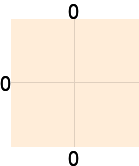

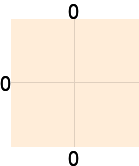

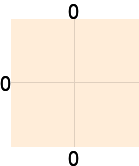

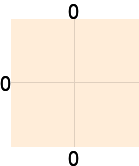

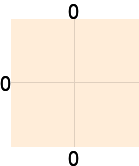

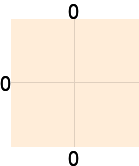

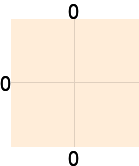

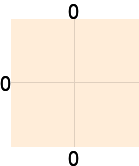

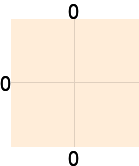

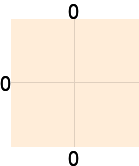

In [23]:
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(10):
    enplot.pshow(enmap.enmap(SDN(DSJ[2]-DSJ[2]).copy()[j], wcs))DSJ[2]

0.25363213


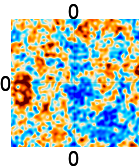

6.5782256


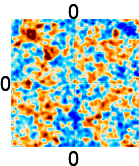

-0.48198804


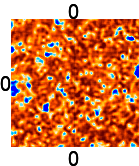

82.11448


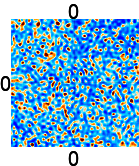

187.1267


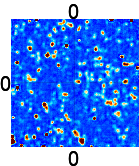

In [16]:
SDS_train = datasets.SehgalDataSet(output_dir, "train_tertiary081120", dtype=np.float32)
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(5):
    print(np.max((SDS_train[1].copy())[j]))
    enplot.pshow(enmap.enmap(SDN(SDS_train[0]).copy()[j], wcs))